# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-17 22:15:30.391626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 22:15:30.422132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-17 22:15:31.506244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:15:31.510303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:15:31.510442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-17 22:15:31.517956: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:15:31.518154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 22:15:31.518231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-17 22:15:32.685925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


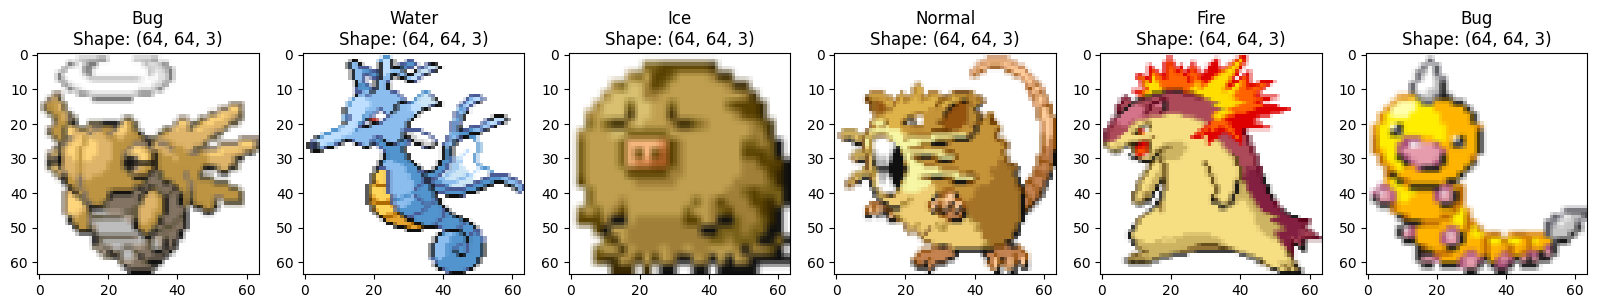

2024-04-17 22:15:33.233273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


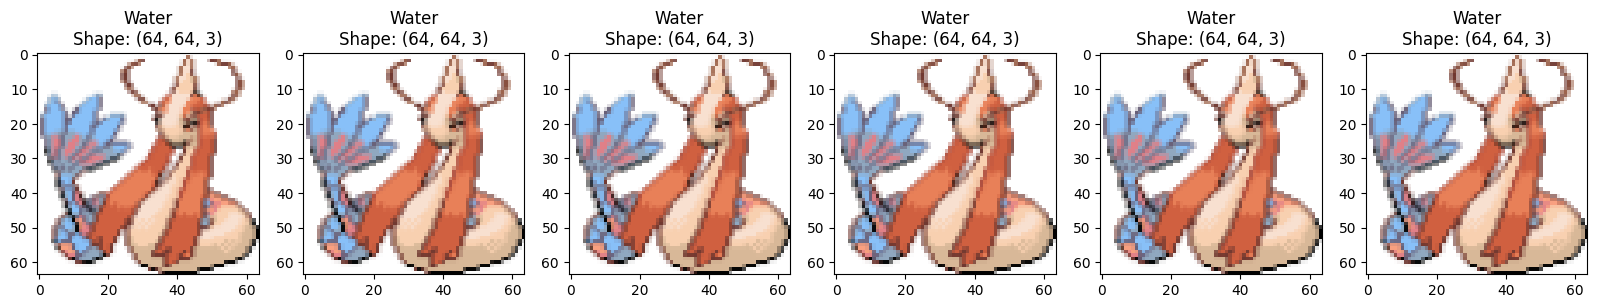

2024-04-17 22:15:33.717002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-17 22:15:33.718174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(256).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

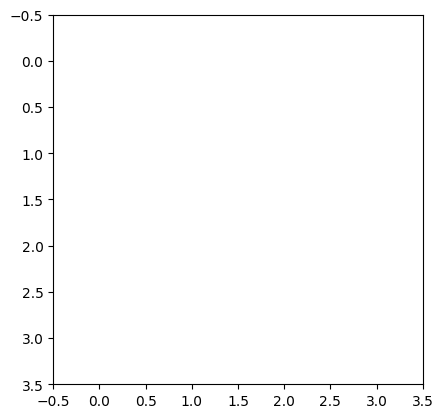

In [7]:
# get the image and the label
for img, label in dataset_example.take(1):
    img_example = img[0]
    label_example = label[0]
    break

# get the coordinates of the bottom right corner of the pokemon
x = 60
y = 60
w = 50
h = 50

# Slice the tensor to get the pixel values within the background area
img_white_area = img_example[y : y + h, x : x + w, :]

plt.imshow(img_white_area)

In [8]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-17 22:15:34.927732: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-17 22:15:36.931116: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - loss: 1.0885
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.8765
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - loss: 0.7552
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.8246

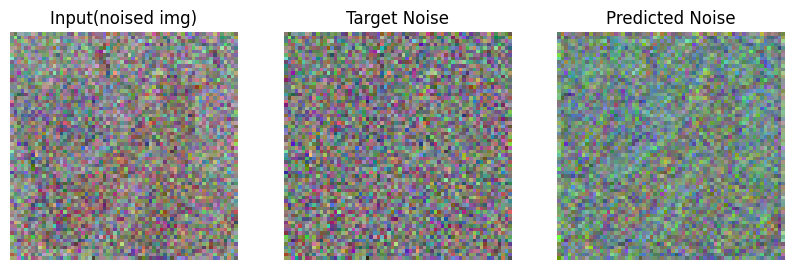

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.005429059, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5913773, shape=(), dtype=float32)


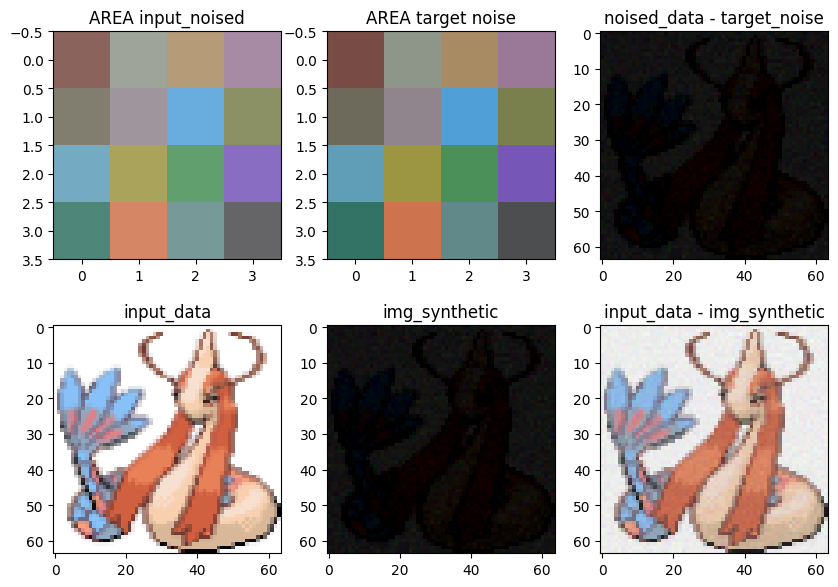

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - loss: 0.7330
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.6559
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.4949
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.3789
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.4841

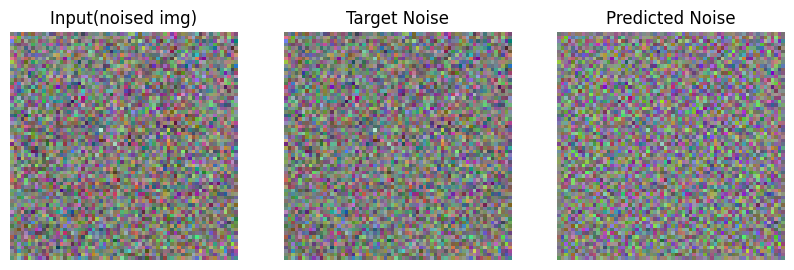

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00050116, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6427877, shape=(), dtype=float32)


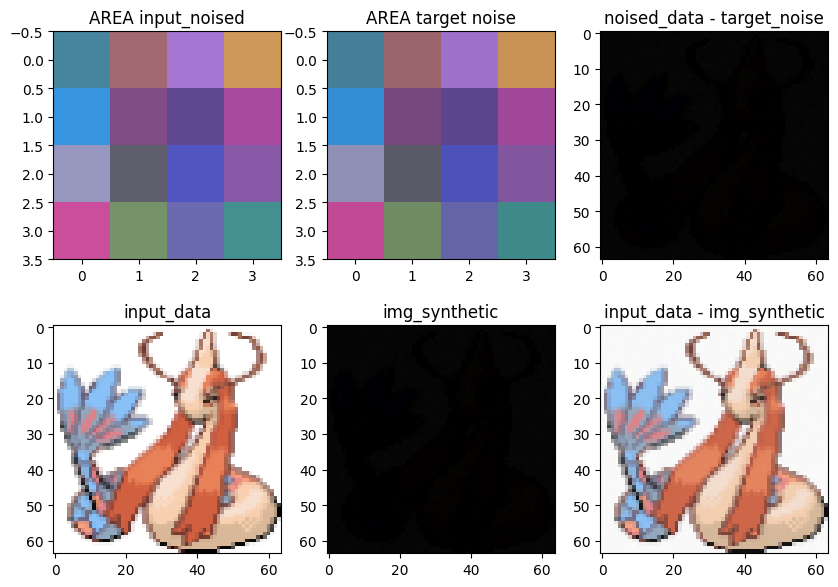

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 0.4303
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1936
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 0.3927
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.2656
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.1846

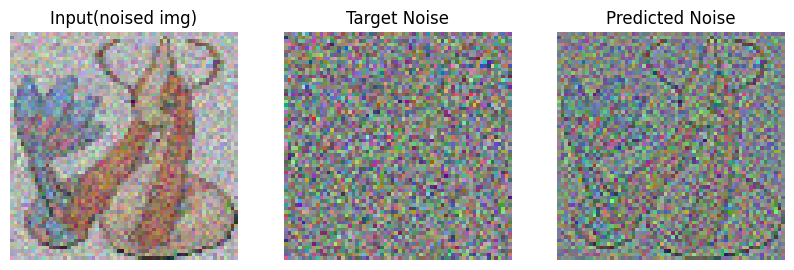

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.040588666, shape=(), dtype=float32)
MSE:  tf.Tensor(0.48580265, shape=(), dtype=float32)


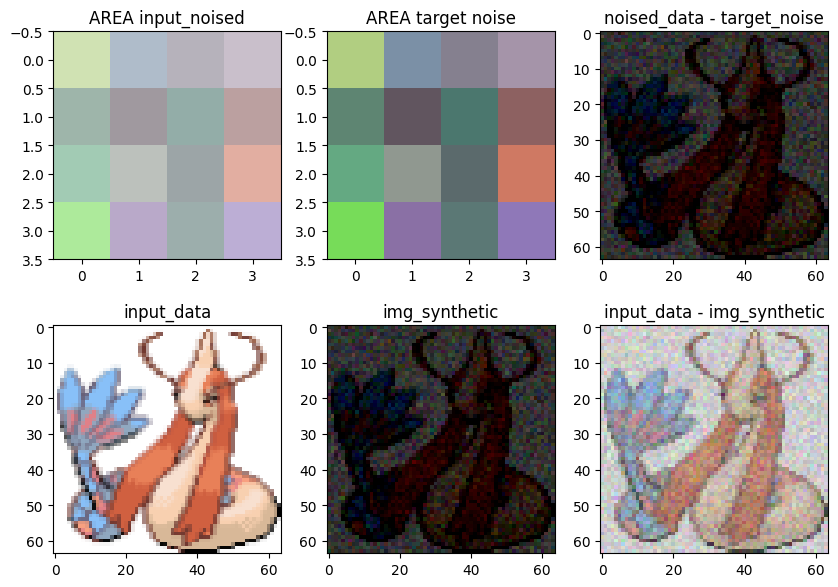

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - loss: 0.1641
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.2181
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1041
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.3378
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.2476

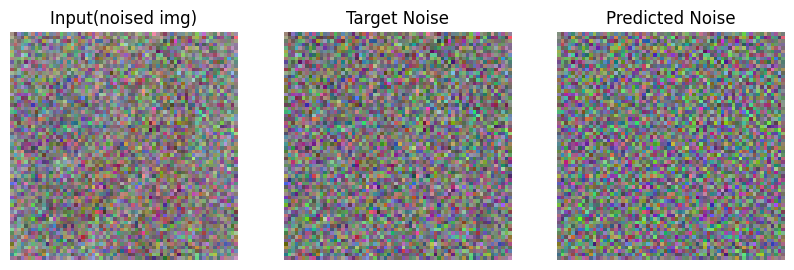

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.003315417, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6034507, shape=(), dtype=float32)


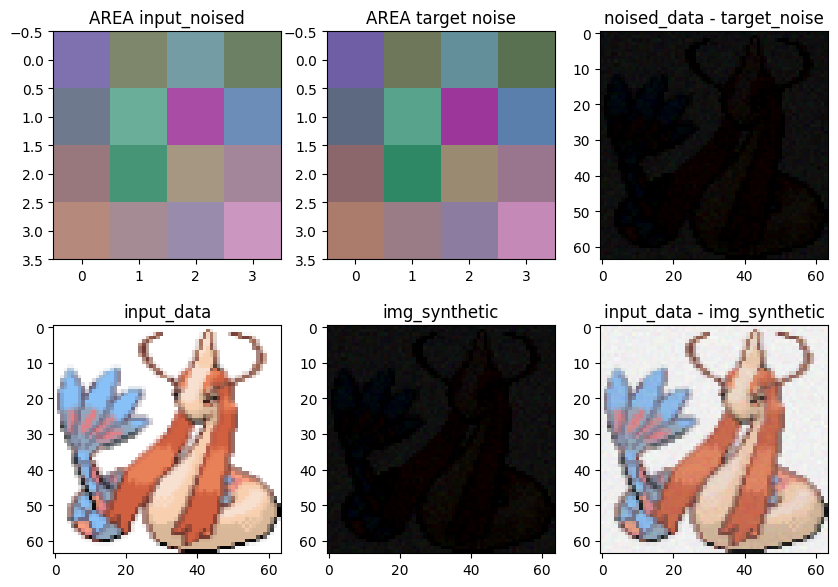

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - loss: 0.2201
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.1774
Epoch 18/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 0.2118
Epoch 19/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1200
Epoch 20/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.1079

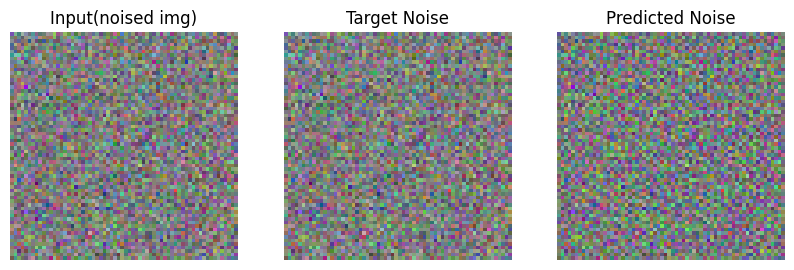

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(4.1105255e-11, shape=(), dtype=float32)
MSE:  tf.Tensor(0.65833026, shape=(), dtype=float32)


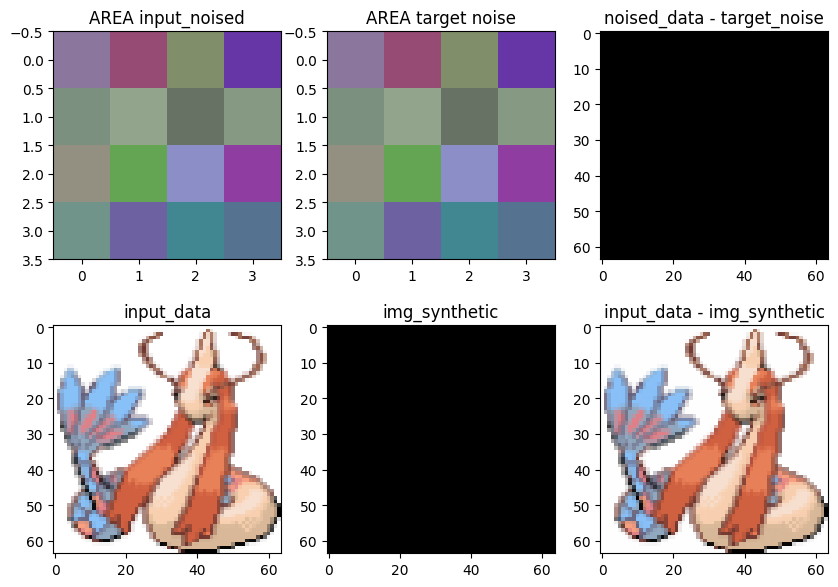

Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 23.83it/s]


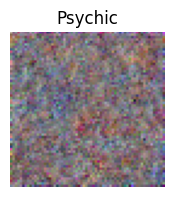

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0959  
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.0786
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.2659
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1331
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.2183

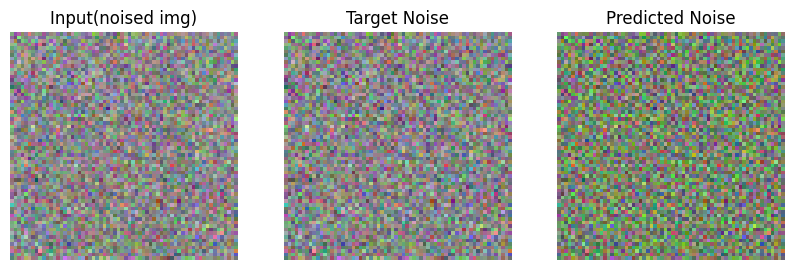

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0006072699, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6347186, shape=(), dtype=float32)


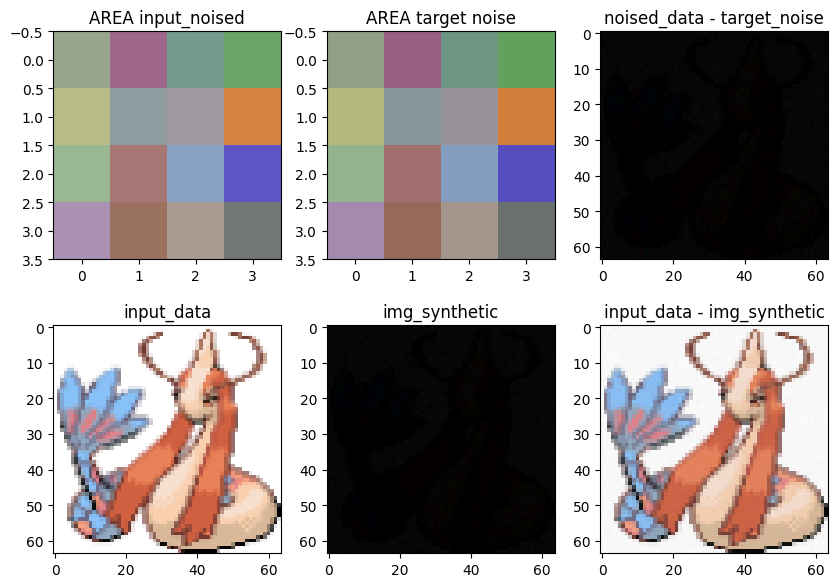

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 0.1941
Epoch 25/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - loss: 0.1938
Epoch 26/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.2815
Epoch 27/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 0.1612
Epoch 28/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1957

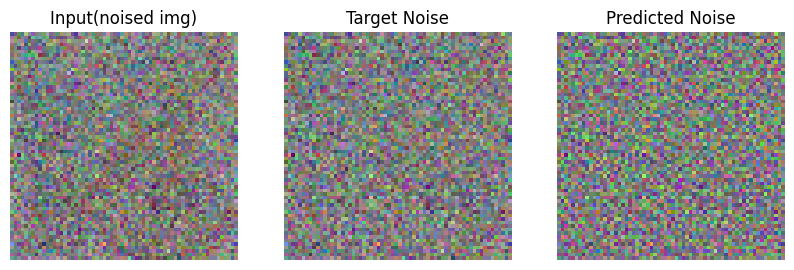

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00032089502, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6534241, shape=(), dtype=float32)


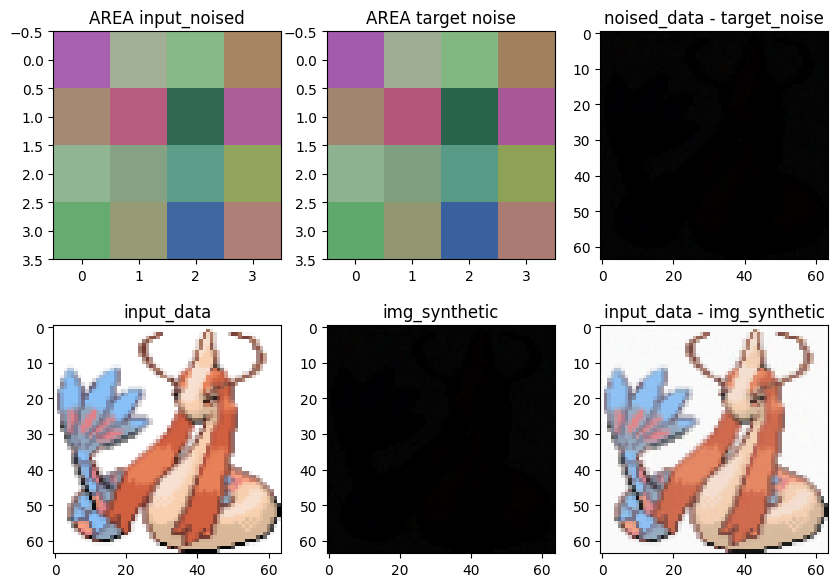

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - loss: 0.1739
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1070
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1554
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1816
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.1398

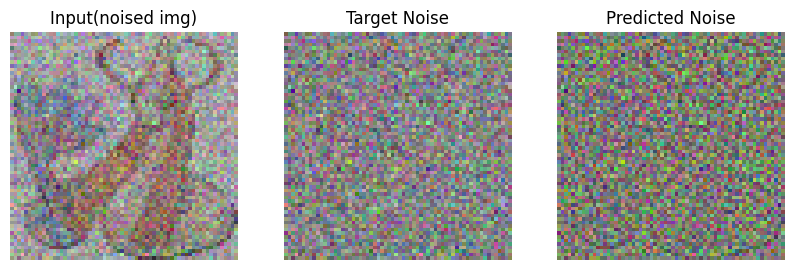

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.014189281, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5631857, shape=(), dtype=float32)


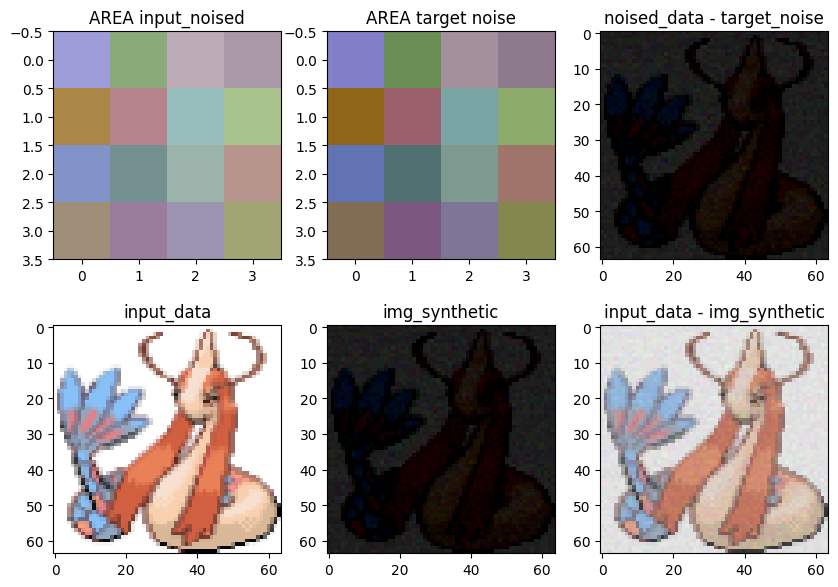

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - loss: 0.1243
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0809
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.1801
Epoch 35/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.2652
Epoch 36/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1379

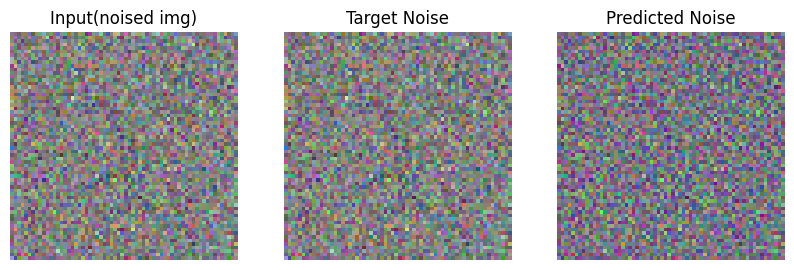

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(2.1453632e-05, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6552777, shape=(), dtype=float32)


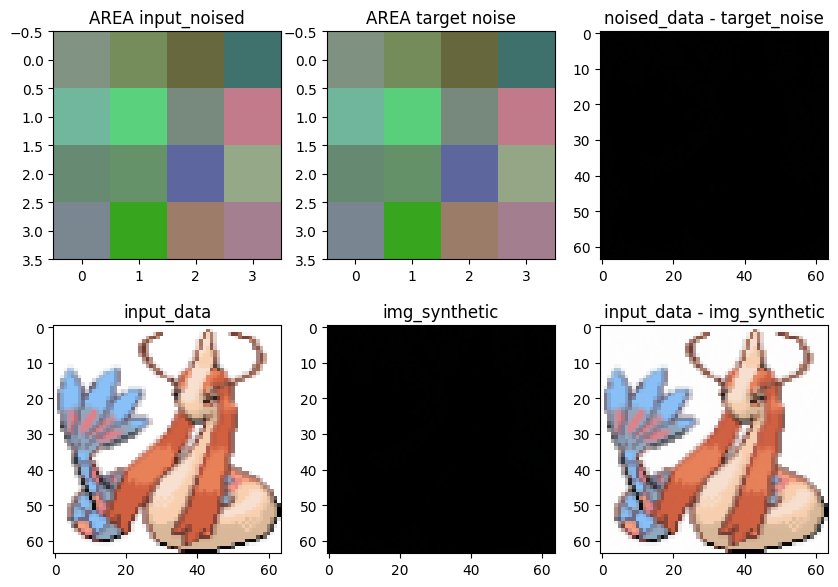

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 0.1226
Epoch 37/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.2264
Epoch 38/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0778
Epoch 39/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.1234
Epoch 40/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.4035

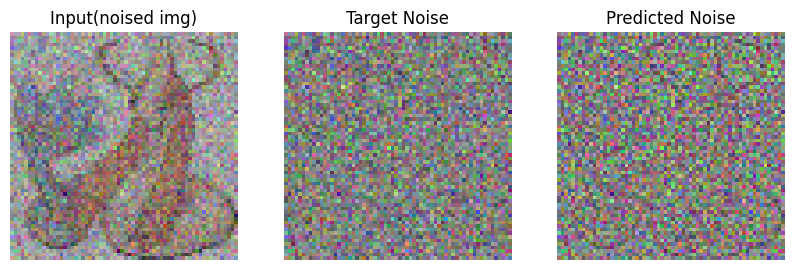

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.014844467, shape=(), dtype=float32)
MSE:  tf.Tensor(0.55790347, shape=(), dtype=float32)


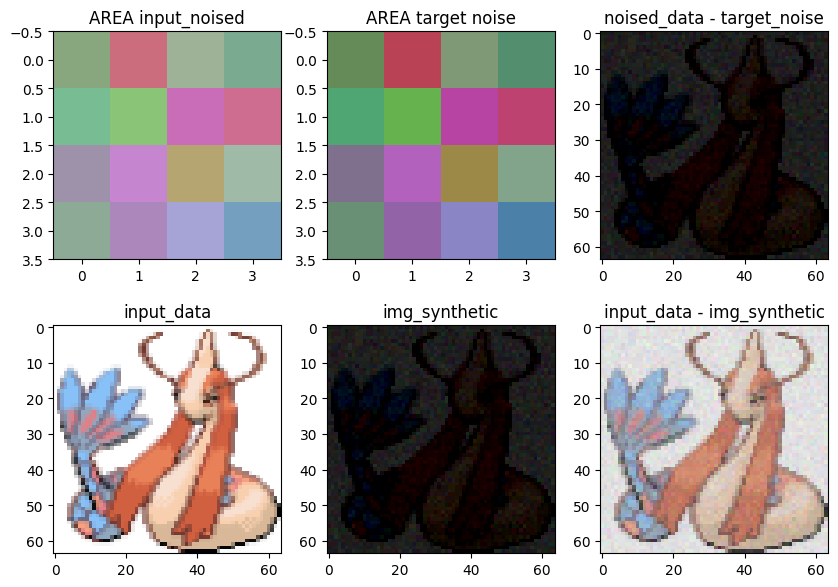

Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 24.04it/s]


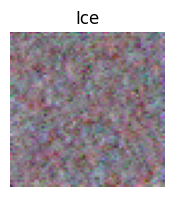

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.3586  
Epoch 41/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.0962
Epoch 42/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1621
Epoch 43/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.1317
Epoch 44/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.1708

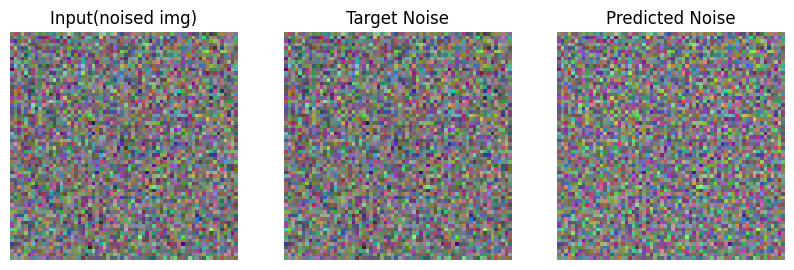

MSE area:  tf.Tensor(2.9814859e-05, shape=(), dtype=float32)
MSE:  tf.Tensor(0.65344024, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


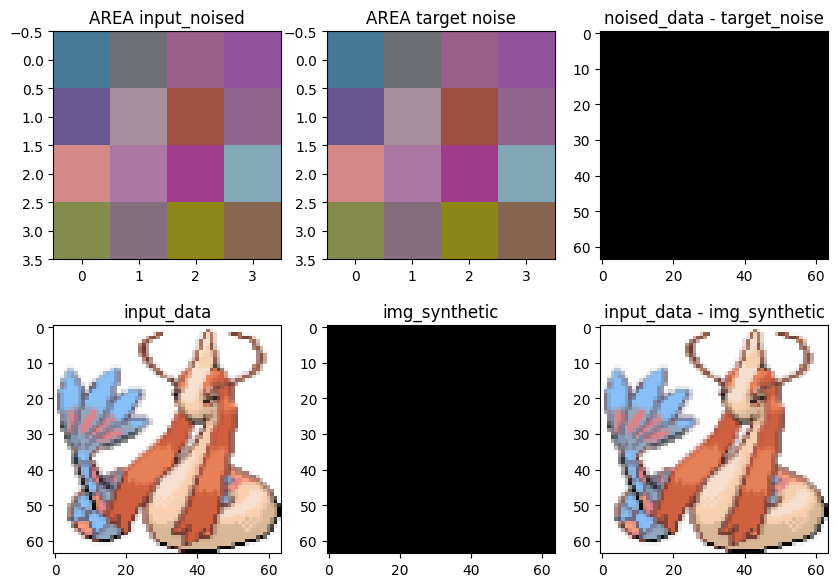

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - loss: 0.1519
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1167
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1124
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1454
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.2533

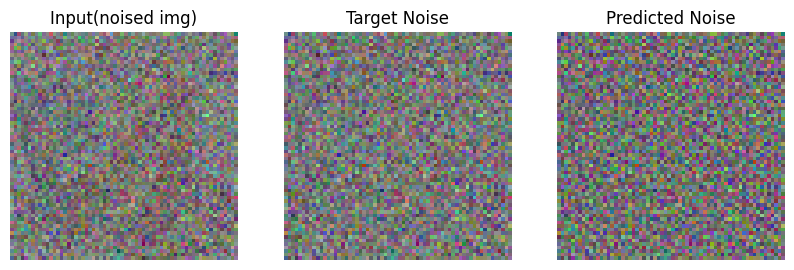

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00068874046, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6429332, shape=(), dtype=float32)


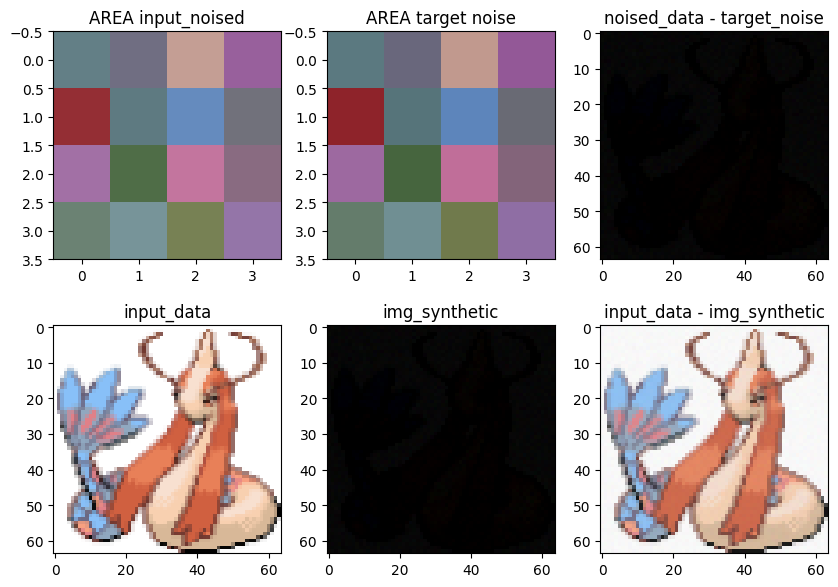

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 0.2251
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.1258
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1075
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.1224
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.1900

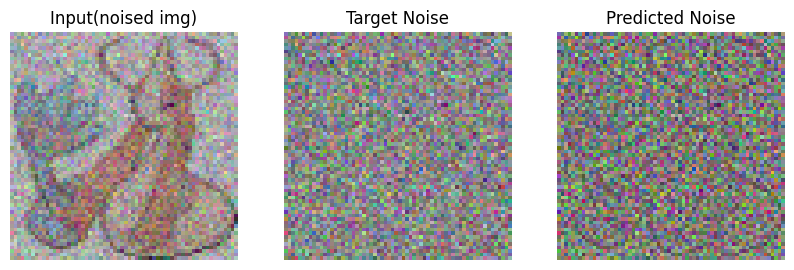

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.020329231, shape=(), dtype=float32)
MSE:  tf.Tensor(0.54227275, shape=(), dtype=float32)


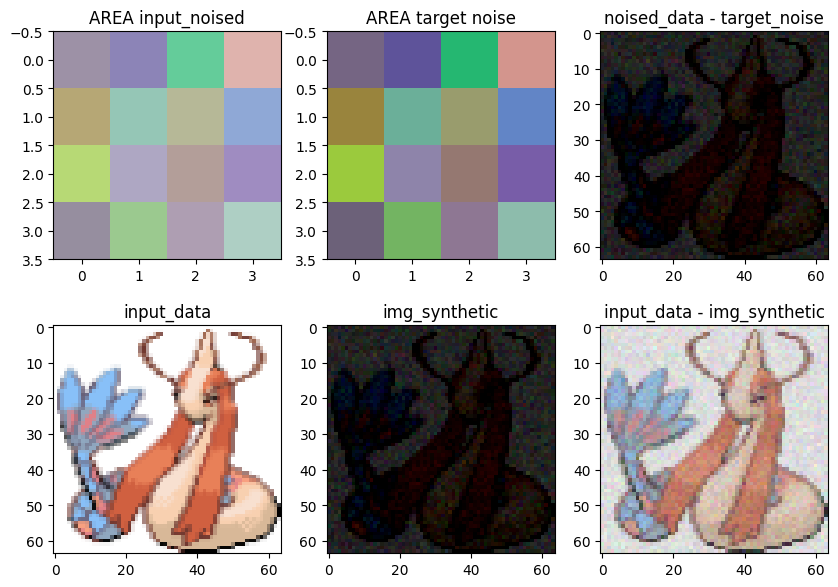

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - loss: 0.1689
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.4495
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1568
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.1152
Epoch 56/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1567

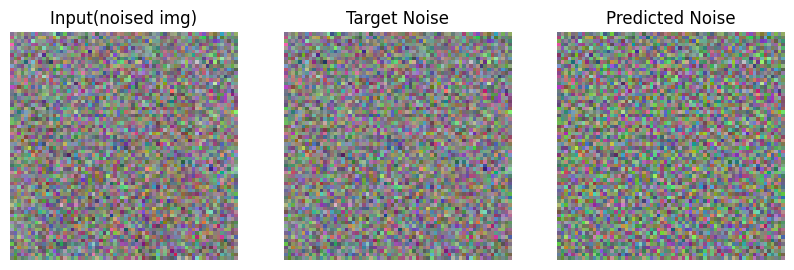

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0002790173, shape=(), dtype=float32)
MSE:  tf.Tensor(0.64863247, shape=(), dtype=float32)


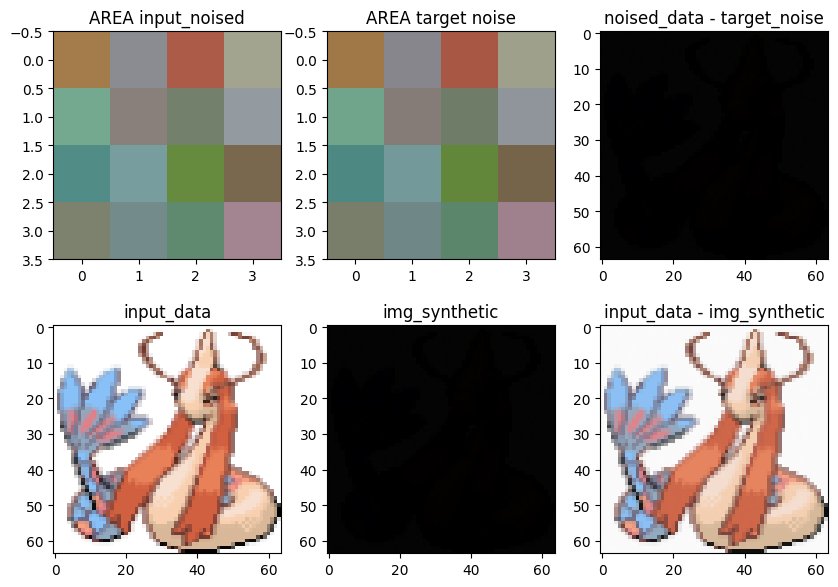

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 0.1393
Epoch 57/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - loss: 0.1418
Epoch 58/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0725
Epoch 59/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.2048
Epoch 60/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0663

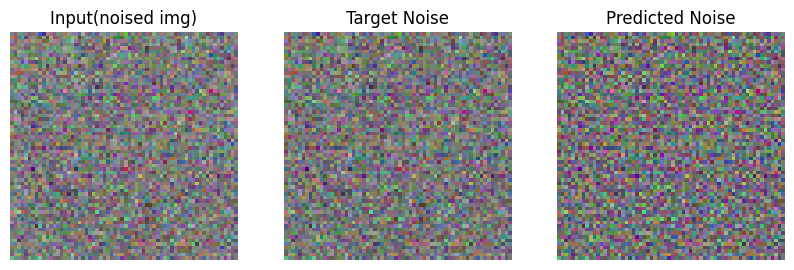

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00048582387, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6323274, shape=(), dtype=float32)


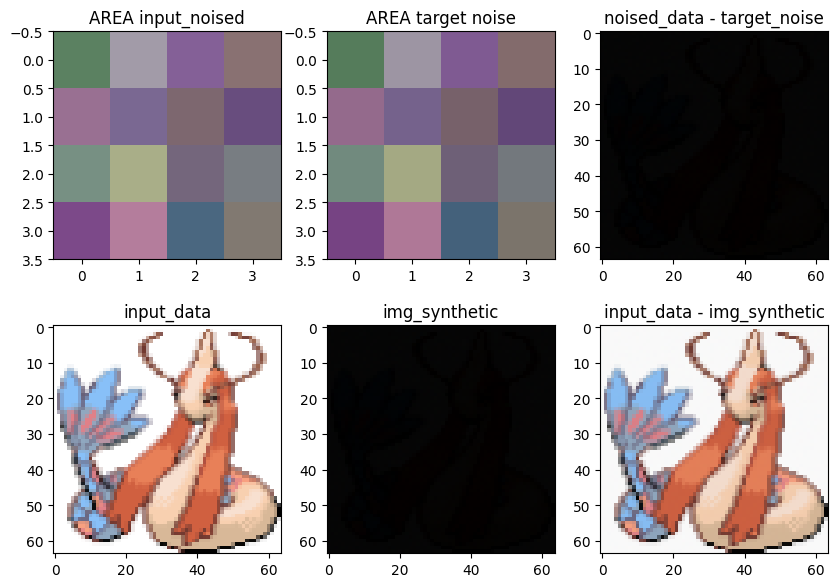

Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.68it/s]


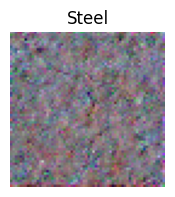

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0589  
Epoch 61/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1055
Epoch 62/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.1613
Epoch 63/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1454
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.1119

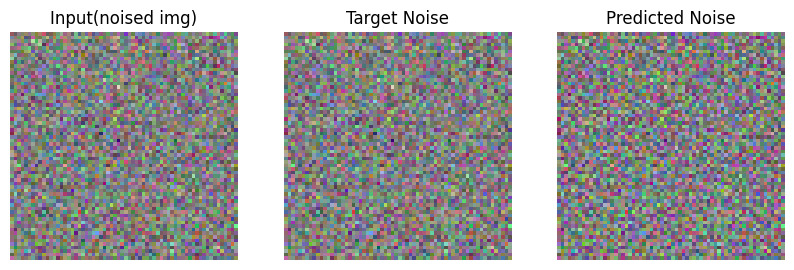

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(1.8873791e-15, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6594232, shape=(), dtype=float32)


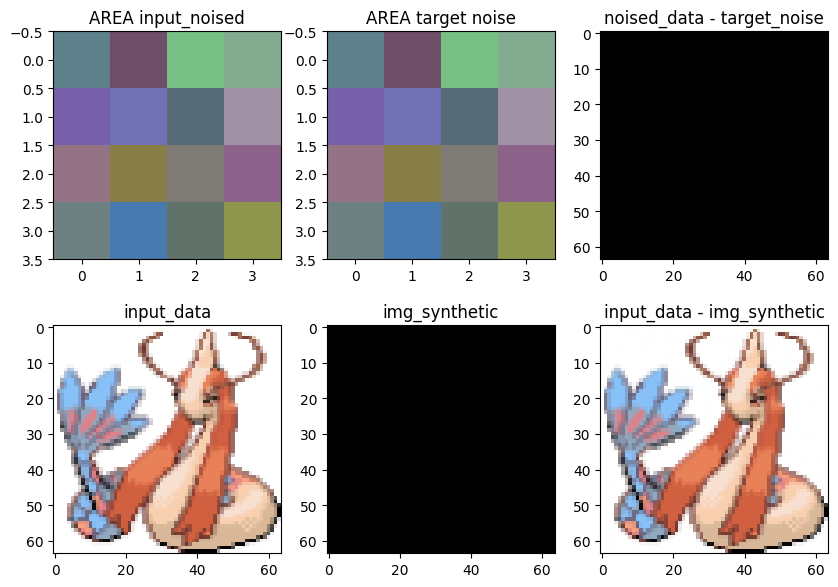

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - loss: 0.0995
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.1299
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - loss: 0.1983
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.0914
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.1148

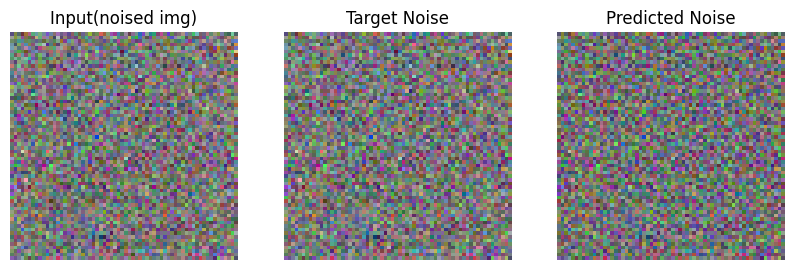

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(9.601418e-05, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6517107, shape=(), dtype=float32)


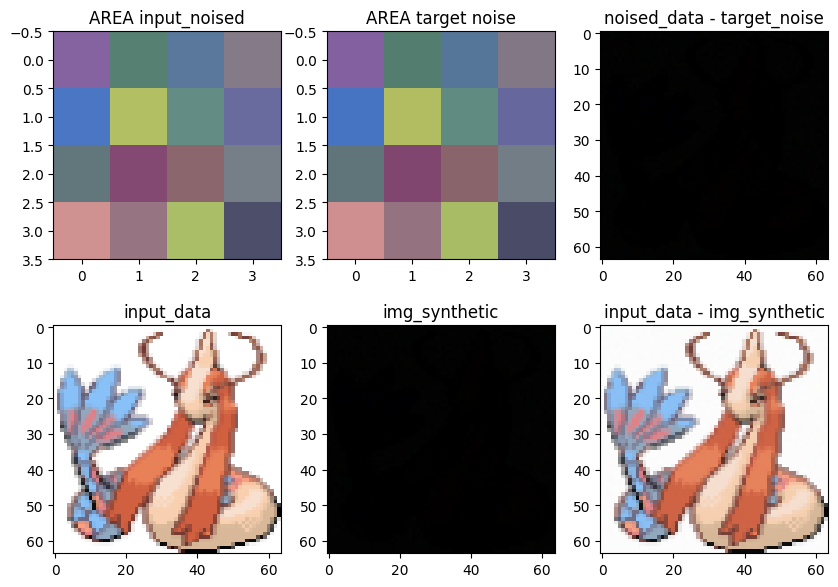

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - loss: 0.1021
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - loss: 0.0647
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0999
Epoch 71/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1768
Epoch 72/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.3294

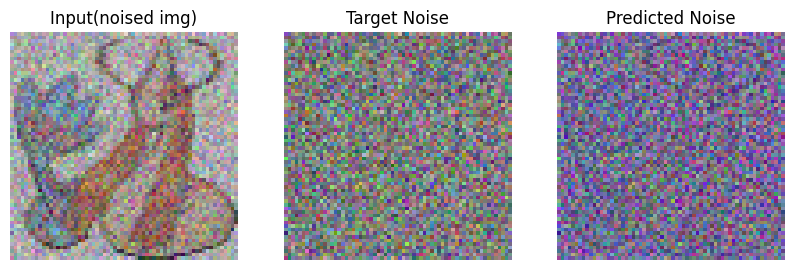

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.03146093, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5041041, shape=(), dtype=float32)


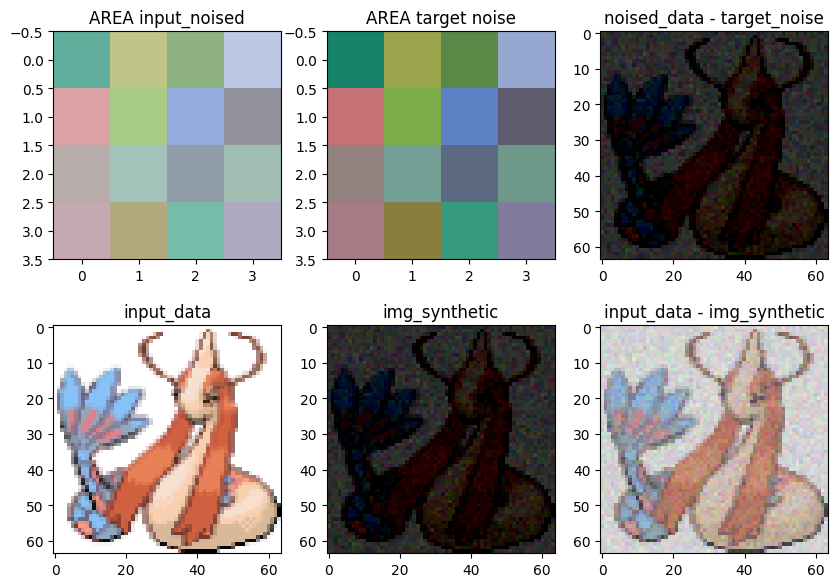

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 0.2928
Epoch 73/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.2956
Epoch 74/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.1301
Epoch 75/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.1051
Epoch 76/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.1475

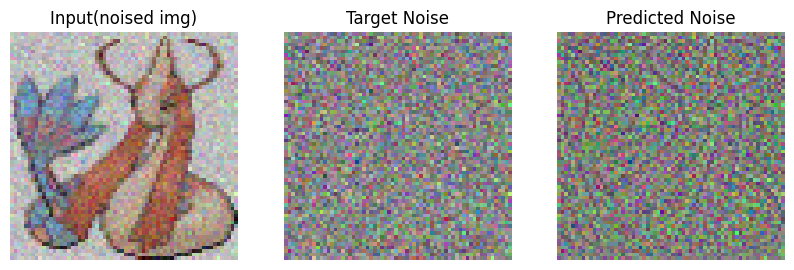

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.04504351, shape=(), dtype=float32)
MSE:  tf.Tensor(0.49685228, shape=(), dtype=float32)


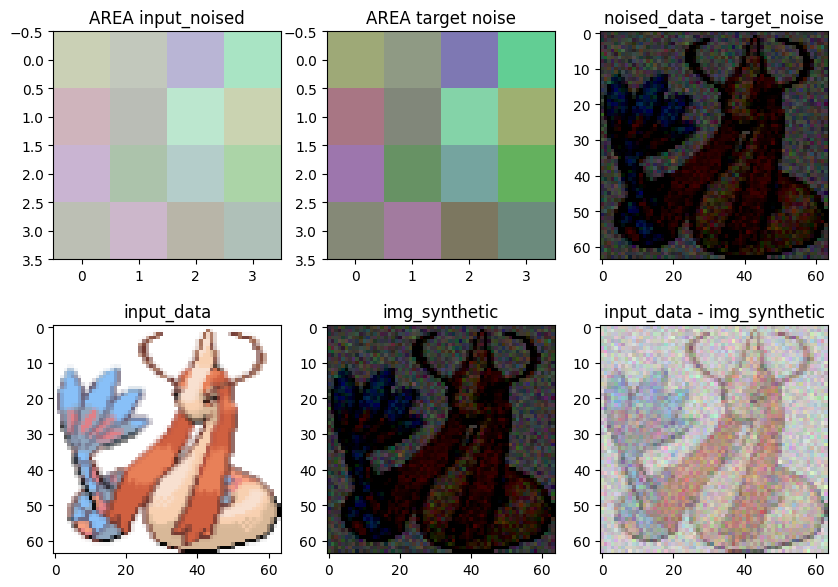

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - loss: 0.1311
Epoch 77/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.1275
Epoch 78/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0601
Epoch 79/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0593
Epoch 80/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.2851

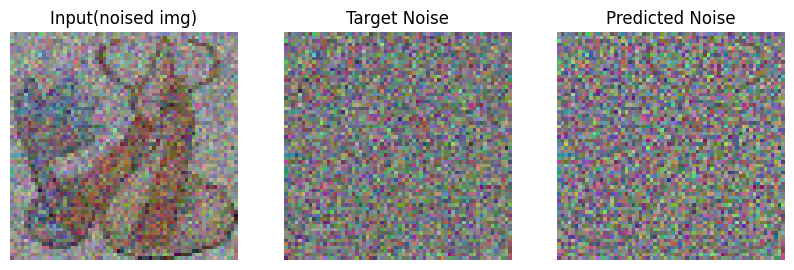

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.009798237, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5969432, shape=(), dtype=float32)


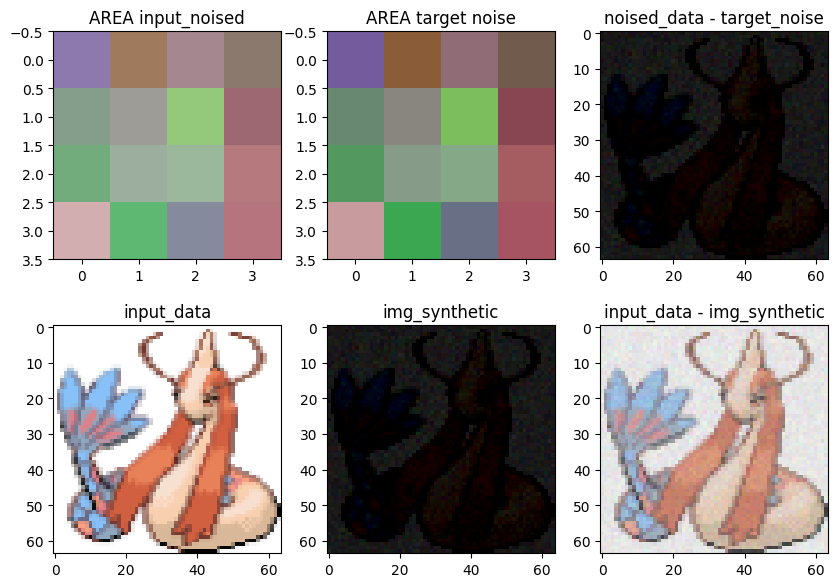

Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.72it/s]


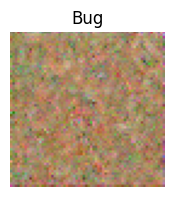

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.2534  
Epoch 81/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1094
Epoch 82/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.1174
Epoch 83/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0899
Epoch 84/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0900

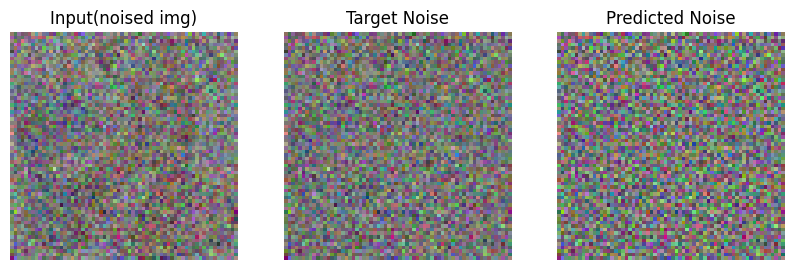

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0016098326, shape=(), dtype=float32)
MSE:  tf.Tensor(0.62930673, shape=(), dtype=float32)


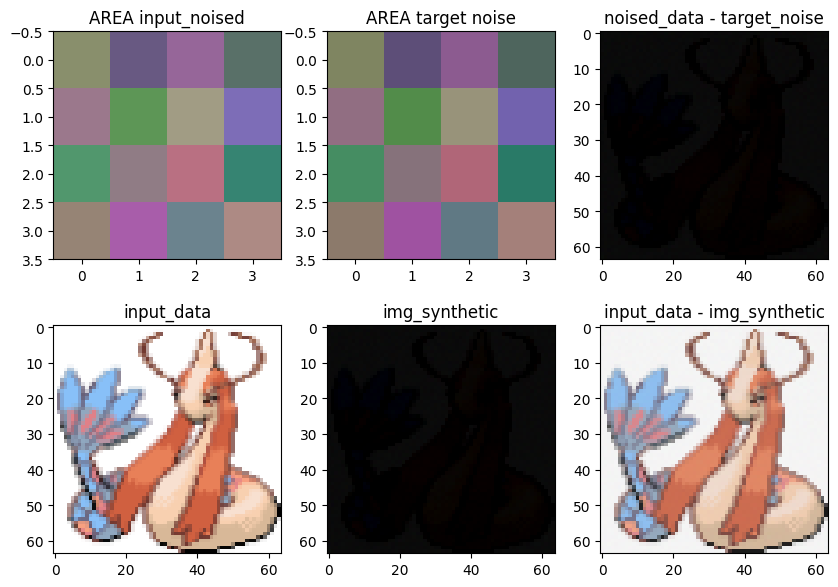

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - loss: 0.0800
Epoch 85/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.1219
Epoch 86/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1297
Epoch 87/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0957
Epoch 88/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0816

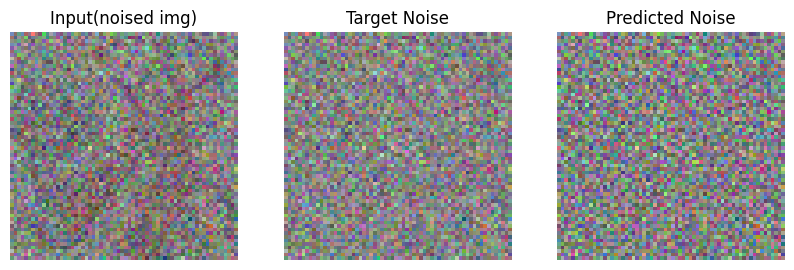

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(1.7763568e-15, shape=(), dtype=float32)
MSE:  tf.Tensor(0.68955994, shape=(), dtype=float32)


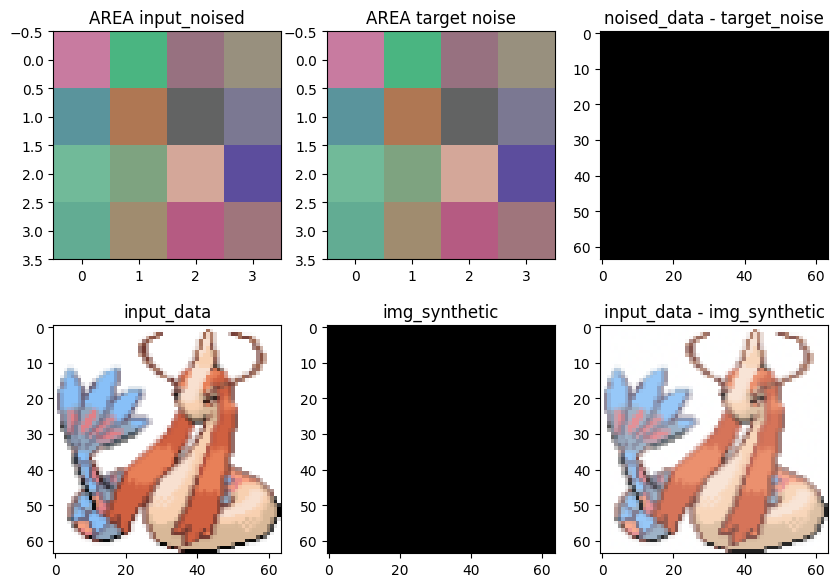

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - loss: 0.0725
Epoch 89/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 0.2040
Epoch 90/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0774
Epoch 91/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1094
Epoch 92/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1170

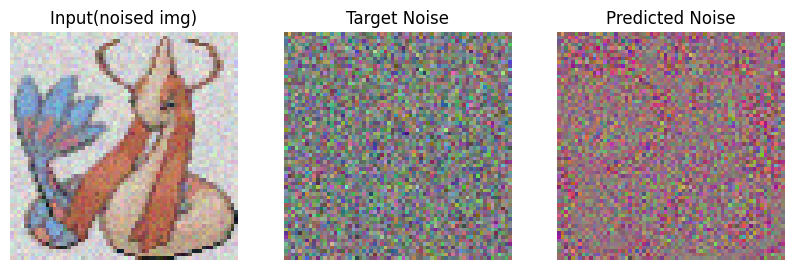

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.121509135, shape=(), dtype=float32)
MSE:  tf.Tensor(0.3623022, shape=(), dtype=float32)


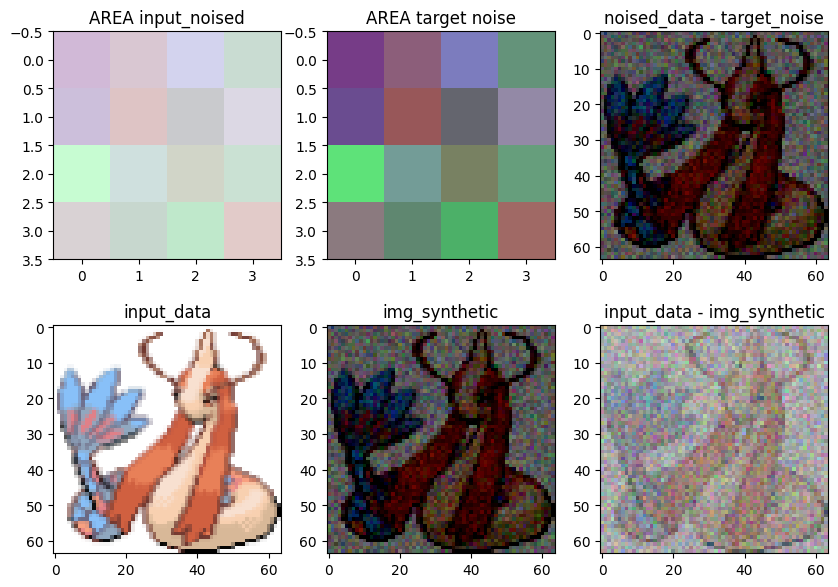

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - loss: 0.1040
Epoch 93/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 0.2213
Epoch 94/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1543
Epoch 95/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0845
Epoch 96/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.1581

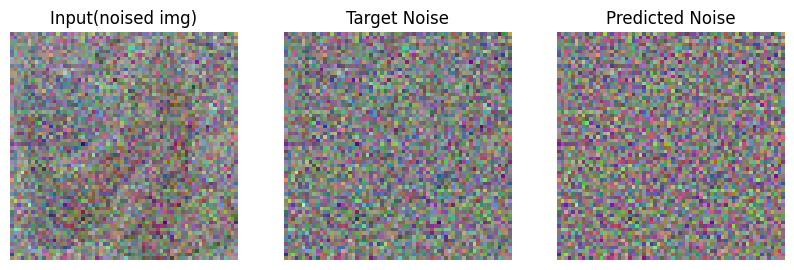

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.002208723, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6251729, shape=(), dtype=float32)


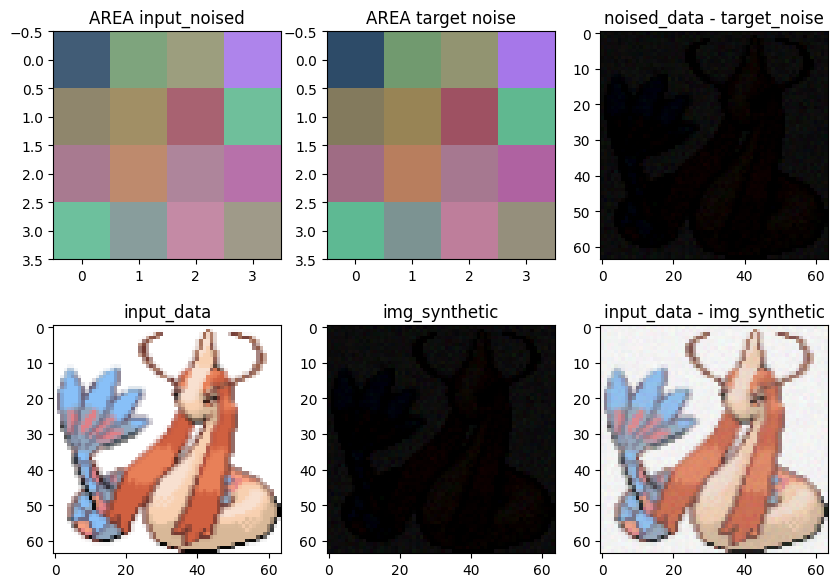

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - loss: 0.1405
Epoch 97/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0699
Epoch 98/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.1156
Epoch 99/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.1881
Epoch 100/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1167

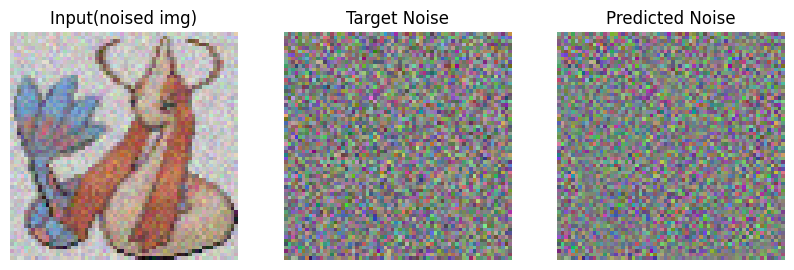

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.084451474, shape=(), dtype=float32)
MSE:  tf.Tensor(0.4249796, shape=(), dtype=float32)


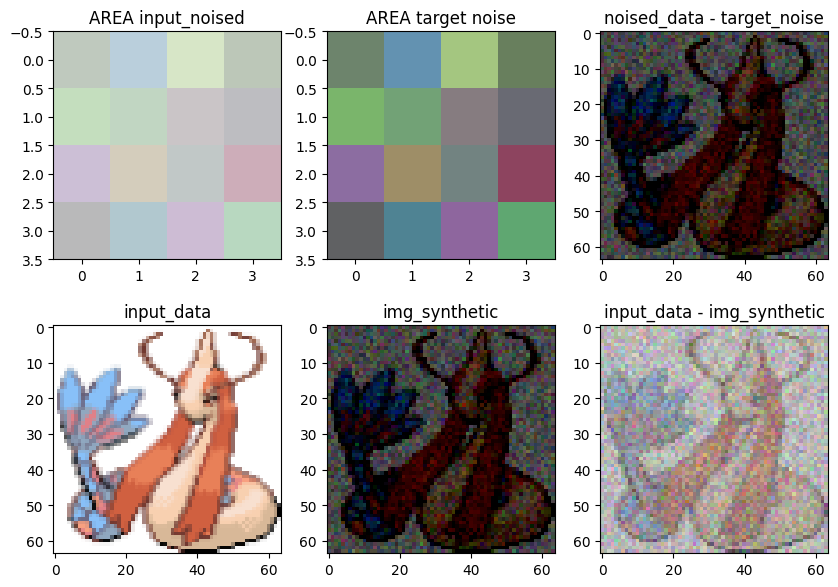

Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.43it/s]


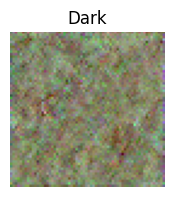

8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 0.1037  


In [9]:
tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[PlottingCallback(model, 4), DiffusionCallback(model, 20)],
)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 10)])

Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.68it/s]


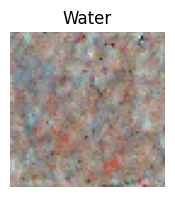

In [10]:
model.plot_samples(1, "Water")

Generating sample 1/4


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.56it/s]


Generating sample 2/4


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.70it/s]


Generating sample 3/4


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.37it/s]


Generating sample 4/4


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.33it/s]


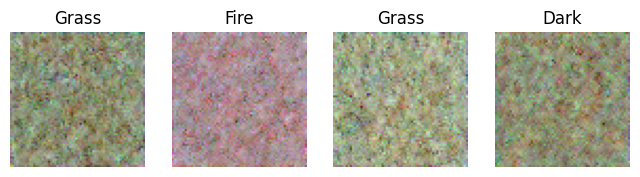

In [11]:
model.plot_samples(4)

In [12]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)